In [1]:
# %pip install numpy
# %pip install scikit-learn
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install pylatexenc
# %pip install opencv-python
# %pip install qiskit
# %pip install qiskit_machine_learning
# %pip install joblib
# %pip install pandas
# %pip install seaborn
# %pip install imblearn

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from monai.transforms import ScaleIntensity
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_machine_learning.algorithms import QSVC
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.utils.loss_functions import SVCLoss
from qiskit_machine_learning.kernels.algorithms.quantum_kernel_trainer import QuantumKernelTrainer
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from joblib import Parallel, delayed
from tqdm import tqdm
from utils.utils import QKTCallback

#### Download latest version https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [2]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# print("Path to dataset files:", path)

#### Define dataset paths

In [3]:
train_path_norm = f'{path}/chest_xray/train/NORMAL'
train_path_pneu = f'{path}/chest_xray/train/PNEUMONIA'
test_path_norm = f'{path}/chest_xray/test/NORMAL'
test_path_pneu = f'{path}/chest_xray/test/PNEUMONIA'

#### Count files in directory

In [4]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.png', '.jpeg'))])

In [ ]:
print("Length train_path_norm:", count_images(train_path_norm))
print("Length train_path_pneu:", count_images(train_path_pneu))
print("Length test_path_norm:", count_images(test_path_norm))
print("Length test_path_pneu:", count_images(test_path_pneu))

#### Check data

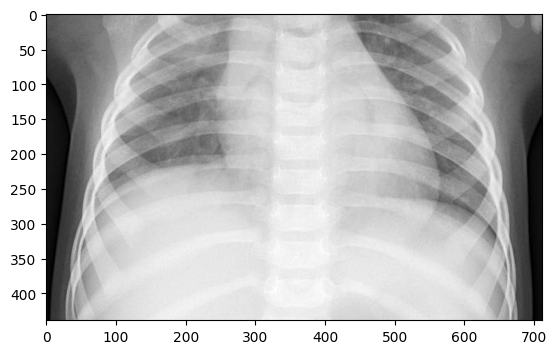

In [6]:
xray_image = cv2.imread(f'{train_path_pneu}/person1_bacteria_1.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(xray_image, cmap='gray')

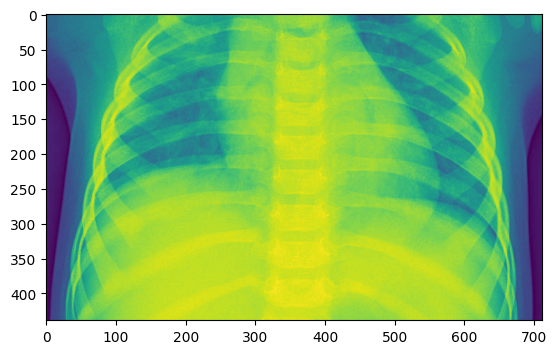

In [7]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
xray_image_scaled = transform_img(xray_image)
colored_xray = cm.viridis(xray_image_scaled)
plt.imshow(colored_xray)

#### Load and preprocess the images

In [8]:
img_size = (256, 256)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and flattens them into numpy arrays.

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img).flatten())
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data, labels

def load_and_limit_data(path, label, num_samples, target_size=(256, 256)):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = [data[i] for i in indices]
    labels = [labels[i] for i in indices]
    return data, labels

#### Display images for train

Found 5216 validated image filenames belonging to 2 classes.


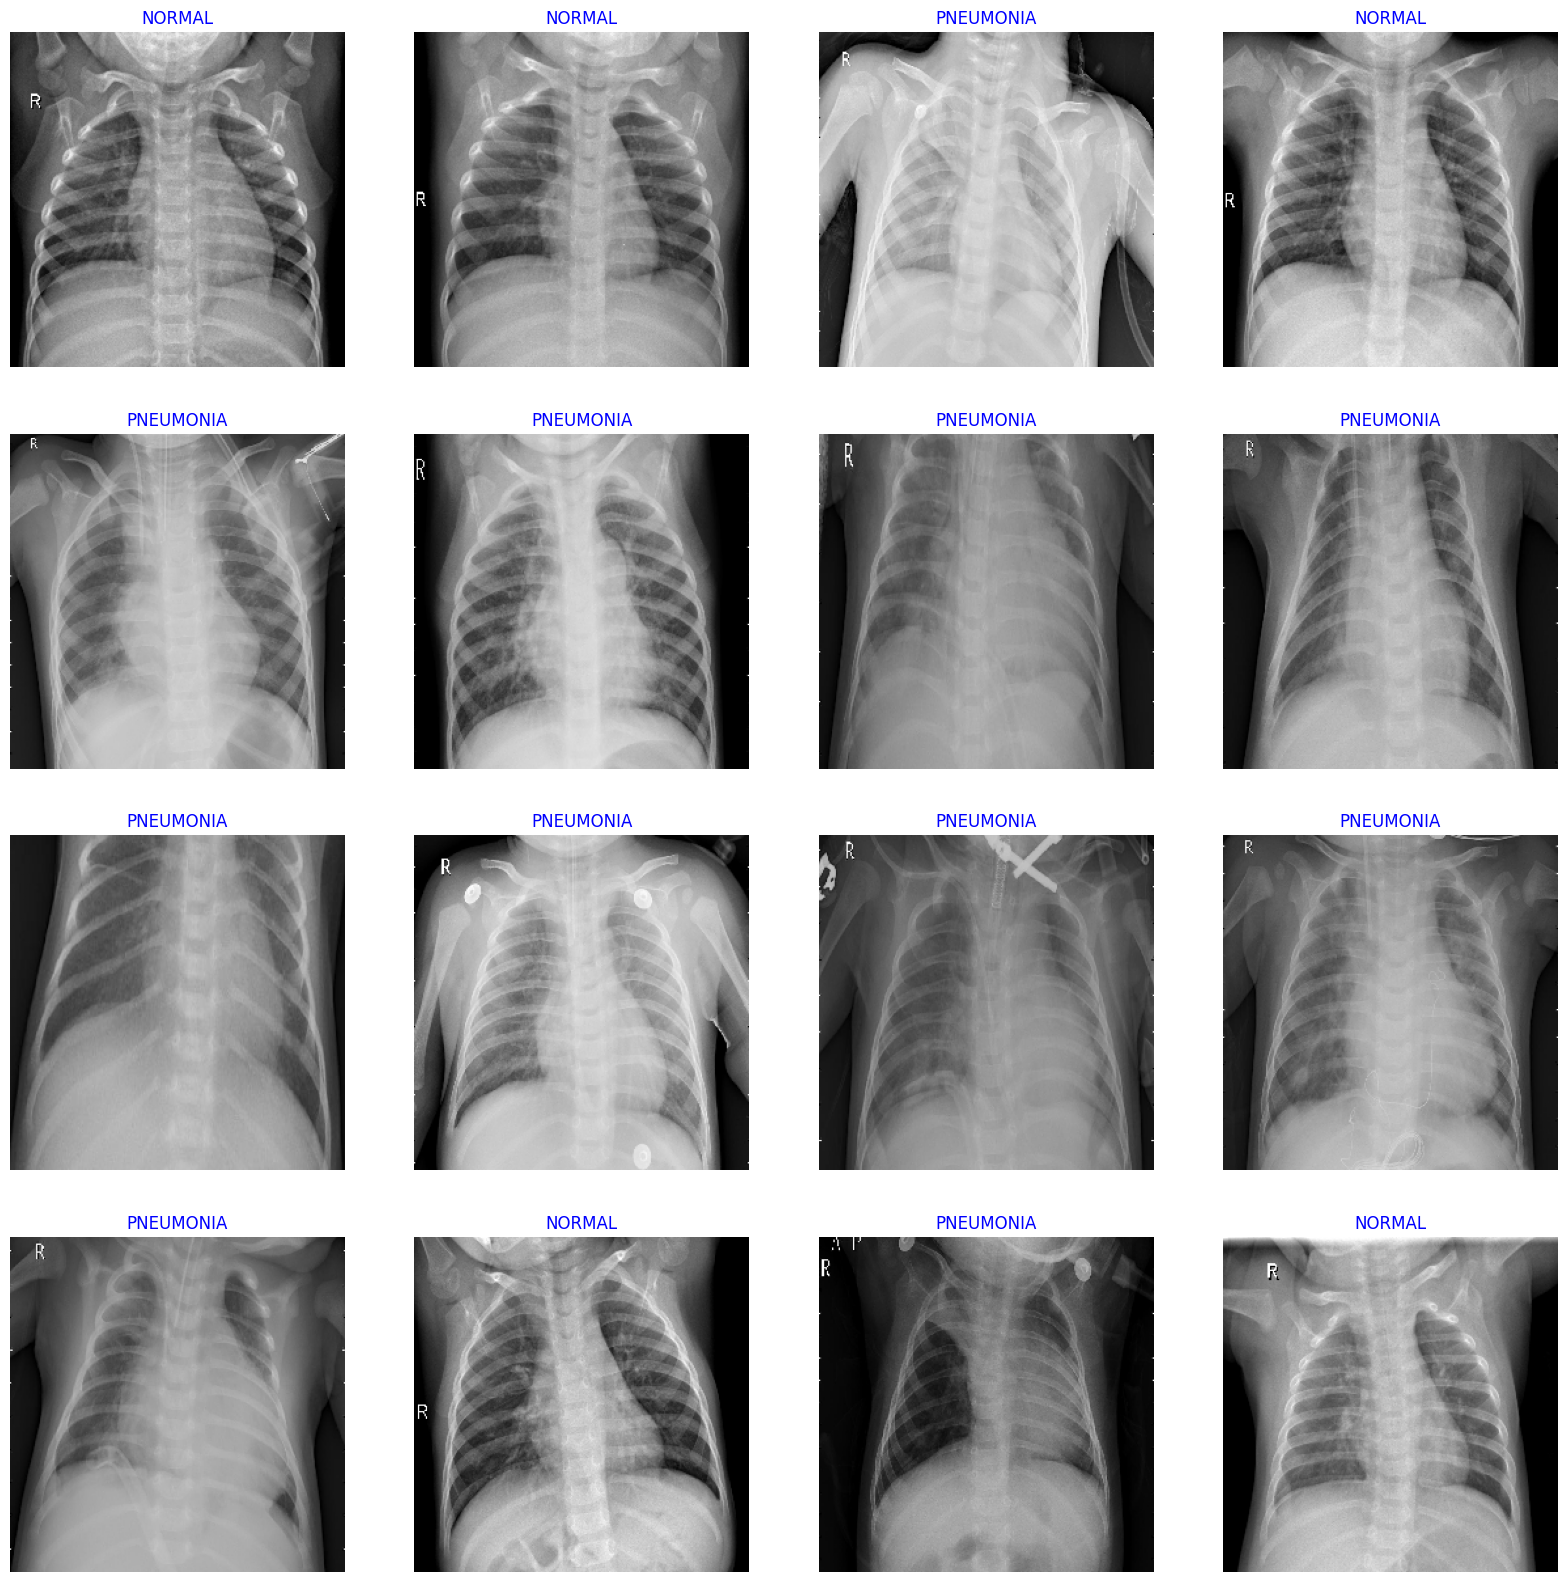

In [9]:
def create_dataframe_from_directory(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    labels = [label] * len(filepaths)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

df_norm = create_dataframe_from_directory(train_path_norm, 'NORMAL')
df_pneu = create_dataframe_from_directory(train_path_pneu, 'PNEUMONIA')

train_df = pd.concat([df_norm, df_pneu], ignore_index=True)

train_df = train_df.sample(frac=1).reset_index(drop=True)

def scalar(img):
    return img

batch_size = 32
tr_gen = ImageDataGenerator(preprocessing_function= scalar)


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size
)

g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen)      
plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255     
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

#### Proportional sampling for balanced dataset

In [10]:
num_samples = 200
num_samples_test = 40

norm_ratio = 1341 / (1341 + 3875)
pneu_ratio = 3875 / (1341 + 3875)

num_samples_norm = int(num_samples * norm_ratio)
num_samples_pneu = int(num_samples * pneu_ratio)

num_samples_norm_test = int(num_samples_test * norm_ratio)
num_samples_pneu_test = int(num_samples_test * pneu_ratio)

#### Training data

In [11]:
train_data_norm, train_labels_norm = load_and_limit_data(train_path_norm, 0, num_samples_norm, target_size=img_size)
train_data_pneu, train_labels_pneu = load_and_limit_data(train_path_pneu, 1, num_samples_pneu, target_size=img_size)
X_train = np.array(train_data_norm + train_data_pneu)
y_train = np.array(train_labels_norm + train_labels_pneu)

#### Data for kernel optimization

In [12]:
X_train_optim = np.array(train_data_norm[:25] + train_data_pneu[:25])
y_train_optim = np.array(train_labels_norm[:25] + train_labels_pneu[:25])

#### PCA for dimensionality reduction & Apply SMOTE for oversampling

In [13]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)
X_train_pca_optim = pca.fit_transform(X_train_optim)

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_train_tensor_optim = torch.tensor(X_train_pca_optim, dtype=torch.float32)
y_train_tensor_optim = torch.tensor(y_train_optim, dtype=torch.float32)

#### Class Weights

In [14]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

#### Test data

In [15]:
test_data_norm, test_labels_norm = load_and_limit_data(test_path_norm, 0, num_samples_norm_test, target_size=img_size)
test_data_pneu, test_labels_pneu = load_and_limit_data(test_path_pneu, 1, num_samples_pneu_test, target_size=img_size)
X_test = np.asarray(test_data_norm + test_data_pneu)
y_test = np.asarray(test_labels_norm + test_labels_pneu)
X_test_pca = pca.transform(X_test)

#### Display the categorized file paths and labels

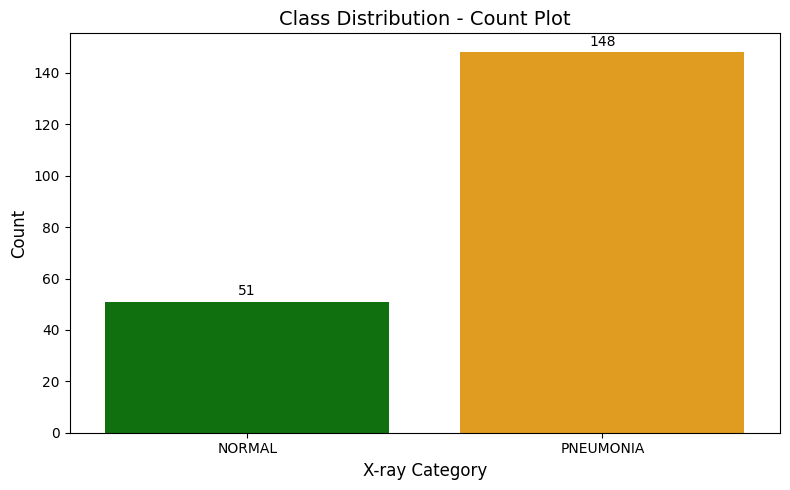

In [16]:
file_paths = train_data_norm + train_data_pneu
labels = train_labels_norm + train_labels_pneu

df = pd.DataFrame({'label': ['NORMAL' if lbl == 0 else 'PNEUMONIA' for lbl in labels]})

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df, 
    x='label', 
    hue='label',
    palette={'NORMAL': 'green', 'PNEUMONIA': 'orange'},
    dodge=False,
    legend=False
)

plt.title('Class Distribution - Count Plot', fontsize=14)
plt.xlabel('X-ray Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 7.5), textcoords='offset points')

plt.tight_layout()
plt.show()


#### Plot the data

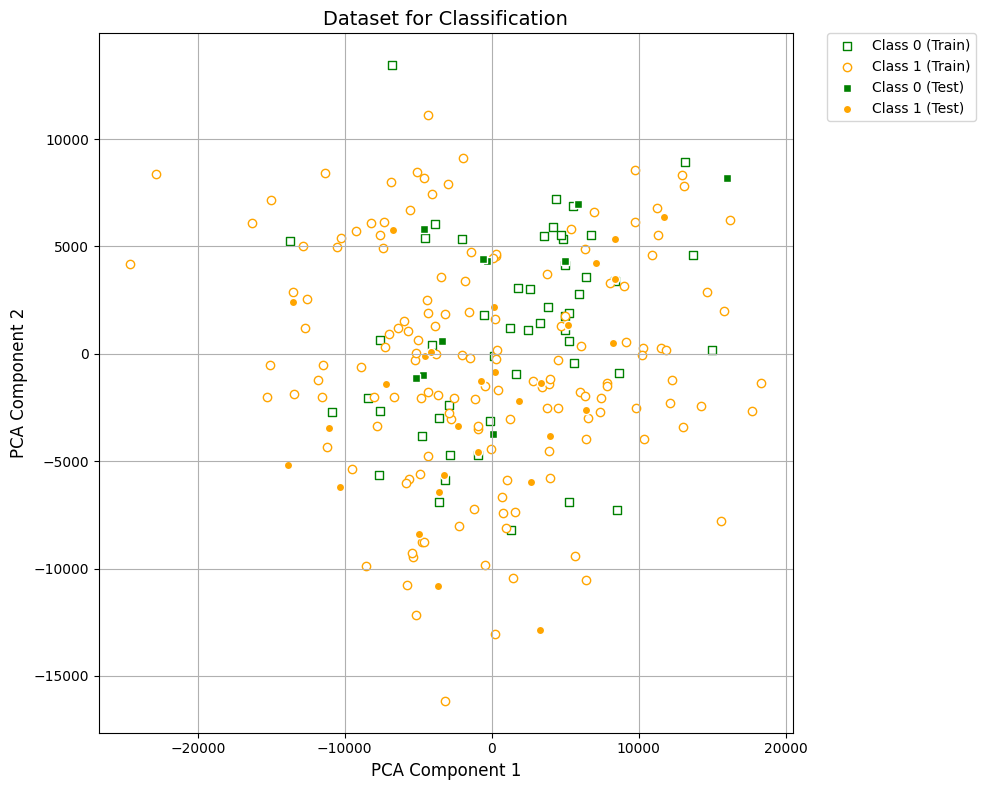

In [17]:
plt.figure(figsize=(10, 8))

plt.scatter(
    X_train_tensor[np.where(y_train_tensor == 0)[0], 0].numpy(),
    X_train_tensor[np.where(y_train_tensor == 0)[0], 1].numpy(),
    marker="s",
    facecolors="w",
    edgecolors="green",
    label="Class 0 (Train)",
)

plt.scatter(
    X_train_tensor[np.where(y_train_tensor == 1)[0], 0].numpy(),
    X_train_tensor[np.where(y_train_tensor == 1)[0], 1].numpy(),
    marker="o",
    facecolors="w",
    edgecolors="orange",
    label="Class 1 (Train)",
)

plt.scatter(
    X_test_pca[np.where(y_test == 0)[0], 0],
    X_test_pca[np.where(y_test == 0)[0], 1],
    marker="s",
    facecolors="green",
    edgecolors="w",
    label="Class 0 (Test)",
)

plt.scatter(
    X_test_pca[np.where(y_test == 1)[0], 0],
    X_test_pca[np.where(y_test == 1)[0], 1],
    marker="o",
    facecolors="orange",
    edgecolors="w",
    label="Class 1 (Test)",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Dataset for Classification", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Quantum Circuit

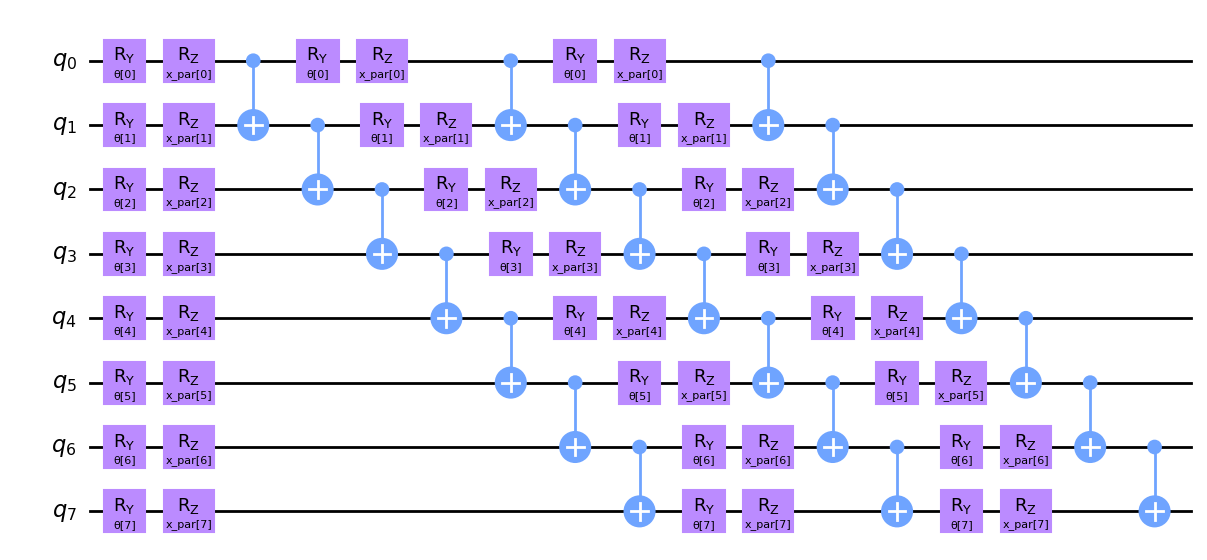

In [18]:
num_qubits = 8
qc = QuantumCircuit(num_qubits)
input_params = ParameterVector("x_par", num_qubits)
training_params = ParameterVector("θ", num_qubits)

for _ in range(3):
    for i, param in enumerate(training_params):
        qc.ry(param, qc.qubits[i])
    for i, param in enumerate(input_params):
        qc.rz(param, qc.qubits[i])
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)

qc.draw("mpl", style="clifford")

#### Initialize the optimizer, Set Up the Quantum Kernel and Quantum Kernel Trainer

In [19]:
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)

quant_kernel = TrainableFidelityQuantumKernel(
    fidelity=fidelity,
    feature_map=qc,
    training_parameters=training_params,
)

cb_qkt = QKTCallback()

spsa_opt = SPSA(
    maxiter=10,
    callback=cb_qkt.callback,
    learning_rate=0.02,
    perturbation=0.01
)

#### Distribute the training process for different initializations across multiple CPU cores.

In [20]:
def train_qkt_with_initial_point(initial_point, X_train, y_train, quant_kernel, loss_function, optimizer):
    """Train QuantumKernelTrainer with a specific initial point."""
    qkt = QuantumKernelTrainer(
        quantum_kernel=quant_kernel,
        loss=loss_function,
        optimizer=optimizer,
        initial_point=initial_point
    )
    results = qkt.fit(X_train, y_train)
    return results

# Parallelize training over different initial points
num_initializations = 4
initial_points = [np.random.randn(num_qubits) * 0.1 for _ in range(num_initializations)]

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_qkt_with_initial_point)(
        initial_point,
        X_train_pca_optim,
        y_train_optim,
        quant_kernel,
        SVCLoss(),
        spsa_opt
    )
    for initial_point in initial_points
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  5.3min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  5.4min finished


#### Extract optimized kernels from results

In [23]:
optimized_kernels = [result.quantum_kernel for result in results]

#### Save the optimized kernel to a file

In [24]:
with open('kernels/optimized_kernel.pkl', 'wb') as f:
    pickle.dump(optimized_kernels, f)

#### Load the optimized kernel from the file

In [76]:
with open('kernels/optimized_kernel.pkl', 'rb') as f:
    loaded_kernel = pickle.load(f)

#### Fit the QSVC

In [25]:
for idx, kernel in enumerate(tqdm(optimized_kernels, desc="Training QSVC for each kernel")):
    print(f"Training QSVC with kernel {idx + 1}/{len(optimized_kernels)}...")
    qsvc = QSVC(quantum_kernel=kernel, class_weight=class_weights_dict, probability=True)
    qsvc.fit(X_train_pca, y_train)
    print(f"Finished training QSVC with kernel {idx + 1}/{len(optimized_kernels)}.\n")

Training QSVC for each kernel:   0%|          | 0/4 [00:00<?, ?it/s]

Training QSVC with kernel 1/4...


Training QSVC for each kernel:  25%|██▌       | 1/4 [02:51<08:35, 171.75s/it]

Finished training QSVC with kernel 1/4.

Training QSVC with kernel 2/4...


Training QSVC for each kernel:  50%|█████     | 2/4 [05:43<05:43, 171.79s/it]

Finished training QSVC with kernel 2/4.

Training QSVC with kernel 3/4...


Training QSVC for each kernel:  75%|███████▌  | 3/4 [08:36<02:52, 172.33s/it]

Finished training QSVC with kernel 3/4.

Training QSVC with kernel 4/4...


Training QSVC for each kernel: 100%|██████████| 4/4 [11:27<00:00, 171.91s/it]

Finished training QSVC with kernel 4/4.



#### Predictions

In [26]:
y_pred = qsvc.predict(X_test_pca)

In [27]:
qsvc_score = qsvc.score(X_test_pca, y_test)

print(f"QSVC classification test score: {qsvc_score:.4f}")

QSVC classification test score: 0.7692


In [28]:
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=y_pred)

print(f"accuracy test: {accuracy_test:.4f}")

accuracy test: 0.5500


#### Save model

In [29]:
qsvc.save('models/QSVC_quantm_trainer_pneumonia.model')

#### Load model

In [13]:
loaded_model = QSVC.load('models/QSVC_quantm_trainer_pneumonia.model')

#### Compute evaluation metrics

In [30]:
classification_rep = metrics.classification_report(y_test, y_pred, output_dict=True, zero_division=True)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, qsvc.decision_function(X_test_pca))

print("Classification Report:", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC Score: {roc_auc}")

Classification Report: {'0': {'precision': 1.0, 'recall': 0.1, 'f1-score': 0.18181818181818182, 'support': 10.0}, '1': {'precision': 0.7631578947368421, 'recall': 1.0, 'f1-score': 0.8656716417910447, 'support': 29.0}, 'accuracy': 0.7692307692307693, 'macro avg': {'precision': 0.881578947368421, 'recall': 0.55, 'f1-score': 0.5237449118046132, 'support': 39.0}, 'weighted avg': {'precision': 0.8238866396761134, 'recall': 0.7692307692307693, 'f1-score': 0.690324600772362, 'support': 39.0}}
Confusion Matrix:
 [[ 1  9]
 [ 0 29]]
ROC AUC Score: 0.6448275862068965


#### Predicted probability for Positive Class

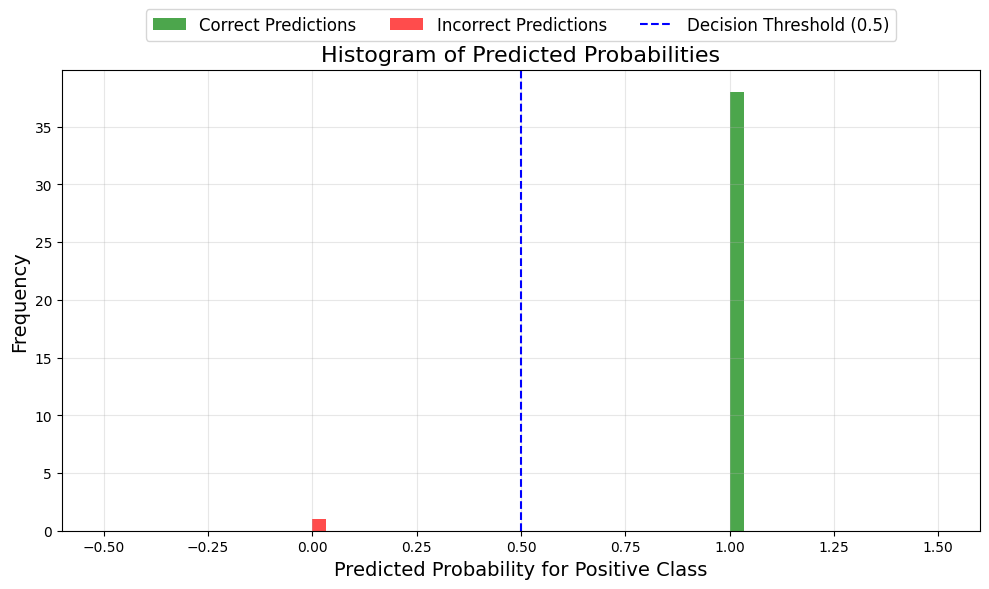

In [31]:
if isinstance(y_pred, np.ndarray):
    y_pred = torch.tensor(y_pred, dtype=torch.float32)

predictions = torch.round(y_pred)
correct_predictions = (predictions == 1)
incorrect_predictions = ~correct_predictions

correct_probs = y_pred[correct_predictions]
incorrect_probs = y_pred[incorrect_predictions]

plt.figure(figsize=(10, 6))

plt.hist(
    correct_probs.numpy(), 
    bins=30, 
    alpha=0.7, 
    color='green', 
    label='Correct Predictions'
)

plt.hist(
    incorrect_probs.numpy(), 
    bins=30, 
    alpha=0.7, 
    color='red', 
    label='Incorrect Predictions'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


#### PCA of model prediction

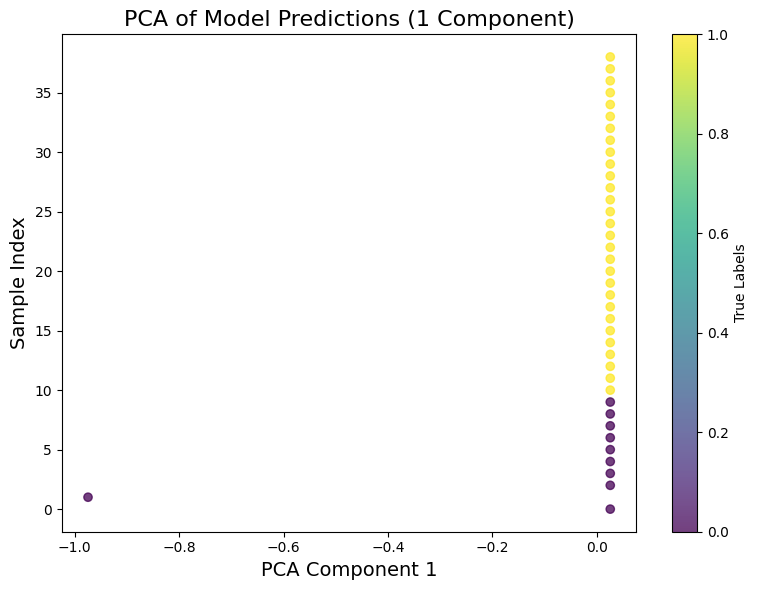

In [32]:
if y_pred.ndim == 1:
    labels_test_reshaped = y_pred.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))

# Scatter plot: features_pca is the transformed feature, y_test_tensor holds true labels
plt.scatter(features_pca, range(len(features_pca)), c=y_test, cmap='viridis', alpha=0.75)

# Add color bar and labels
plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


#### Plot the confusion matrix

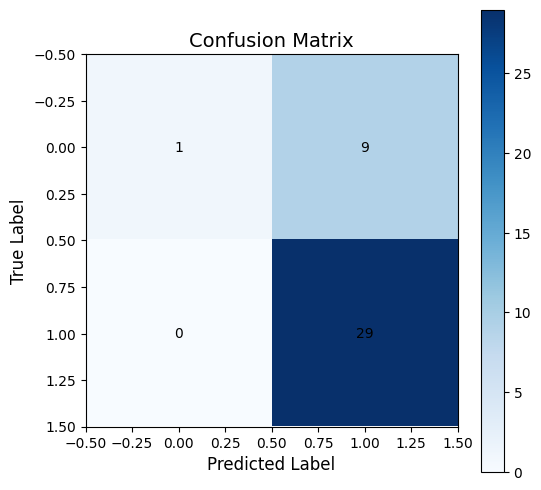

In [ ]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()

#### Plot the ROC curve

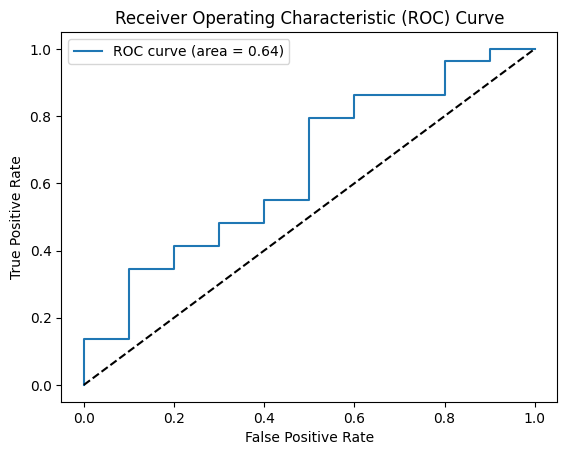

In [34]:
decision_function = qsvc.decision_function(X_test_pca)

fpr, tpr, _ = metrics.roc_curve(y_test, decision_function)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="best")

plt.show()

In [36]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright